In [1]:
from utils import *
from prepare_ds import *
from train_ml import *
from create_map import *
from validation import *
from visualisation import *
from tqdm import tqdm

downgrade_labels = False
force = False

if downgrade_labels:
    src = DEFAULT_PATH["labels"]
    out = DEFAULT_PATH["labels"] + "downgraded/"
    classes_matching = DEFAULT_PATH["labels"] + "classes_matching.csv"
    downgrade_classes(src, out, classes_matching)
    DEFAULT_PATH["labels"] = out

# you can use force=True for re-write all caches.
signs = parse_tifs_from(DEFAULT_PATH["images"], "sign", force=force)
signs = signs.query("type == 'sign'")
labels = parse_tifs_from(DEFAULT_PATH["labels"], "label", force=force)
labels = labels.query("type == 'label'")

# Prepare data for generate_dataset.
year = 2020
only_bands = ["r", "b", "g", "n"]
signs_paths = signs.query(
    f"year == {year} and season == '90d' and band in @only_bands"
).sort_values("band")
signs_paths = signs_paths["path"].to_list()
labels_paths = labels.query(f"year == {year}")["path"].to_list()

Initialization paths...
All paths was initialized.
Load 'sign' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_sign.csv
Load 'label' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_label.csv


In [2]:
config_grid = {
    "resize": ["by_label"],
    "mask_mode": ["secure"],
    "r": [1],
    "percent": [0.1],
    "stratify": [True],
}
store_models = True

best_models = analyse_best_model(
    config_grid, signs_paths, labels_paths, store_models=store_models, verbose=True
)

Training set of models...:   0%|          | 0/1 [00:00<?, ?it/s]

Loading & preparing image data...

Cropping & loading labels by 1st image:
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/reg_64_2020_06_90d_comp.b.tif
Files was loaded.
Loading from cache...
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif
Files was loaded.
Crop labels is done.

Resizing images by 1st label:
Loading from cache...
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/images/reg_64_2020_06_90d_comp.b.tif
Files was loaded.
Loading from cache...
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/images/reg_64_2020_06_90d_comp.g.tif
Files was loaded.
Loading from cache...
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/images/reg_64_2020_06_90d_comp.n.tif
Files was loaded.
Loading from cache...
Loading file: /Users/stephe

Training set of models...: 100%|██████████| 1/1 [00:18<00:00, 18.67s/it]


Classification Report:
              precision    recall  f1-score   support

           1       0.85      0.87      0.86      4967
           2       0.67      0.67      0.67      8399
           3       0.64      0.64      0.64      8399
           4       0.98      0.97      0.98      1563
           5       0.58      0.31      0.40       288
           6       0.60      0.04      0.08        72

    accuracy                           0.72     23688
   macro avg       0.72      0.58      0.60     23688
weighted avg       0.72      0.72      0.72     23688

Confusion Matrix:
[[4343  206  408    7    3    0]
 [ 228 5640 2517    2   11    1]
 [ 509 2418 5411   16   45    0]
 [  15   12   24 1512    0    0]
 [  15   60  123    1   88    1]
 [   2   40   23    0    4    3]]
1: f1=0.7156, mm=secure, r=1, p=0.1, rz=by_label, st=True


In [3]:
take_first = 5
count = take_first if len(best_models) > take_first else len(best_models)
models = []

if not store_models:
    for i in tqdm(range(count), desc="Training models and store it in RAM to fulltest"):
        mm = best_models[i]["mask_mode"]
        rr = best_models[i]["r"]
        pc = best_models[i]["percent"]
        rz = best_models[i]["resize"]
        st = best_models[i]["stratify"]

        z_x, z_y, loaded_tiles, _ = generate_dataset(
            signs_paths,
            labels_paths,
            mask_mode=mm,
            r=rr,
            percent=pc,
            resize=rz,
            stratify=st,
            verbose=False,
        )
        m, report, cf_matrix, f1 = train_model(z_x, z_y, save=False, verbose=False)
        models.append({"model": m, "report": report, "cf_matrix": cf_matrix, "f1": f1})
else:
    for m in best_models[:count]:
        models.append(
            {
                "model": m["model"],
                "report": m["report"],
                "cf_matrix": m["cf_matrix"],
                "f1": m["f1_score"],
            }
        )


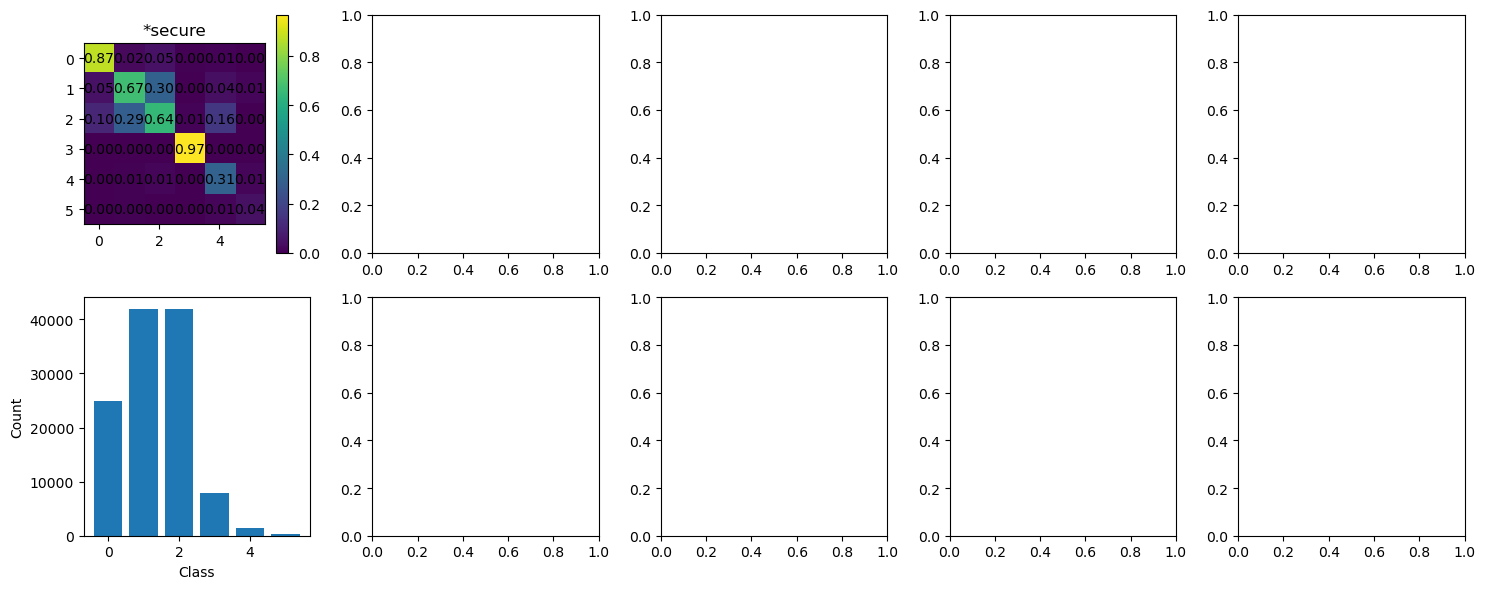

In [4]:
from visualisation import *

spyder_eye(best_models, models)

In [5]:
# Mapping by loaded images from path (10m)
etalons = DEFAULT_PATH["etalons"]
map = "wc"
etalons_list = parse_tifs_from(etalons, typeof="etalon", verbose=False)
etalons_list = etalons_list.query(f"year == {year} and map =='{map}'")["path"].to_list()
only_bands = ["r", "b", "g", "n"]

quality = False
if quality:
    tiles = DEFAULT_PATH["images"] + "tiles/"
    tiles = parse_tifs_from(tiles, typeof="tile", verbose=True)
    tiles = tiles.query("band in @only_bands").sort_values("band")["path"]
    tiles = tiles.to_list()
    loaded_tiles = []
    for t in tiles:
        loaded_tiles.append(load_tif(t, only_first=True, verbose=False))
else:
    _, _, loaded_tiles, _ = generate_dataset(
        signs_paths,
        labels_paths,
        percent=0.0001,
    )

predicted_res = []
for idx, model_dict in enumerate(models[:count]):
    m = model_dict["model"]
    mm = best_models[idx]["mask_mode"]
    f1 = best_models[idx]["f1_score"]
    pc = best_models[idx]["percent"]
    tt = best_models[idx]["train_time"]
    out = f"auto_10m_{f1}_{mm}_{pc}_{tt}.tif"
    predicted_res.append(create_map(loaded_tiles, m, out))

# validation_res = []
# for idx, pred_map in enumerate(predicted_res):
#     val_result = validate_how_tif(pred_map, etalons_list)
#     validation_res.append({"model_idx": idx, "validation": val_result})


Loading & preparing image data...

Cropping & loading labels by 1st image:
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/reg_64_2020_06_90d_comp.b.tif
Files was loaded.
Loading from cache...
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif
Files was loaded.
Crop labels is done.

Resizing images by 1st label:
Loading from cache...
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/images/reg_64_2020_06_90d_comp.b.tif
Files was loaded.
Loading from cache...
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/images/reg_64_2020_06_90d_comp.g.tif
Files was loaded.
Loading from cache...
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/images/reg_64_2020_06_90d_comp.n.tif
Files was loaded.
Loading from cache...
Loading file: /Users/stephe

Creating map...:  33%|███▎      | 2/6 [00:08<00:17,  4.29s/it]


KeyboardInterrupt: 

In [ ]:
# validation_res = []
# for idx, pred_map in enumerate(predicted_res):
#     val_result = validate_how_tif(pred_map, etalons_list)
#     validation_res.append({"model_idx": idx, "validation": val_result})